In [7]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from momaapi import MOMA
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [8]:
moma = MOMA(dir_moma="/data/dir_moma/", paradigm="few-shot")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

In [9]:
def cosine_mean_similarity(x, y):
    # x: n x d
    # y: m x d
    # assume that x, y are not normalized
    
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    
    return torch.mm(x, y.t()).mean()

def smooth_chamfer_similarity(x, y, alpha):
    # x: n x d
    # y: m x d
    # assume that x, y are not normalized
    
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    c = torch.mm(x, y.t())
    
    left_term = torch.logsumexp(alpha*c, dim=1).sum() / (2.*alpha*x.shape[0])
    right_term = torch.logsumexp(alpha*c, dim=0).sum() / (2.*alpha*y.shape[0])
    
    return left_term + right_term

In [13]:
cache = {}
path = "/data/dir_moma/timesformer_captions"
for filename in tqdm(os.listdir(path)):
    with open(os.path.join(path, filename)) as f:
        captions = f.readlines()
    captions = [caption.strip() for caption in captions]

    with torch.no_grad():
        embeddings = sbert_model.encode(captions)
        cache[filename[:-4]] = torch.from_numpy(embeddings)

100%|██████████| 1412/1412 [00:28<00:00, 49.06it/s]


['basketball game # V_1cchOYMFw', 'basketball game # _PxHGJArC00', 'basketball game # Xp1EV1GGPHs', 'basketball game # 24q1O3M9xiw', 'basketball game # l7-0DL-707w', 'basketball game # m0MtHFfhhFs', 'basketball game # OXxcLxvdHBc']


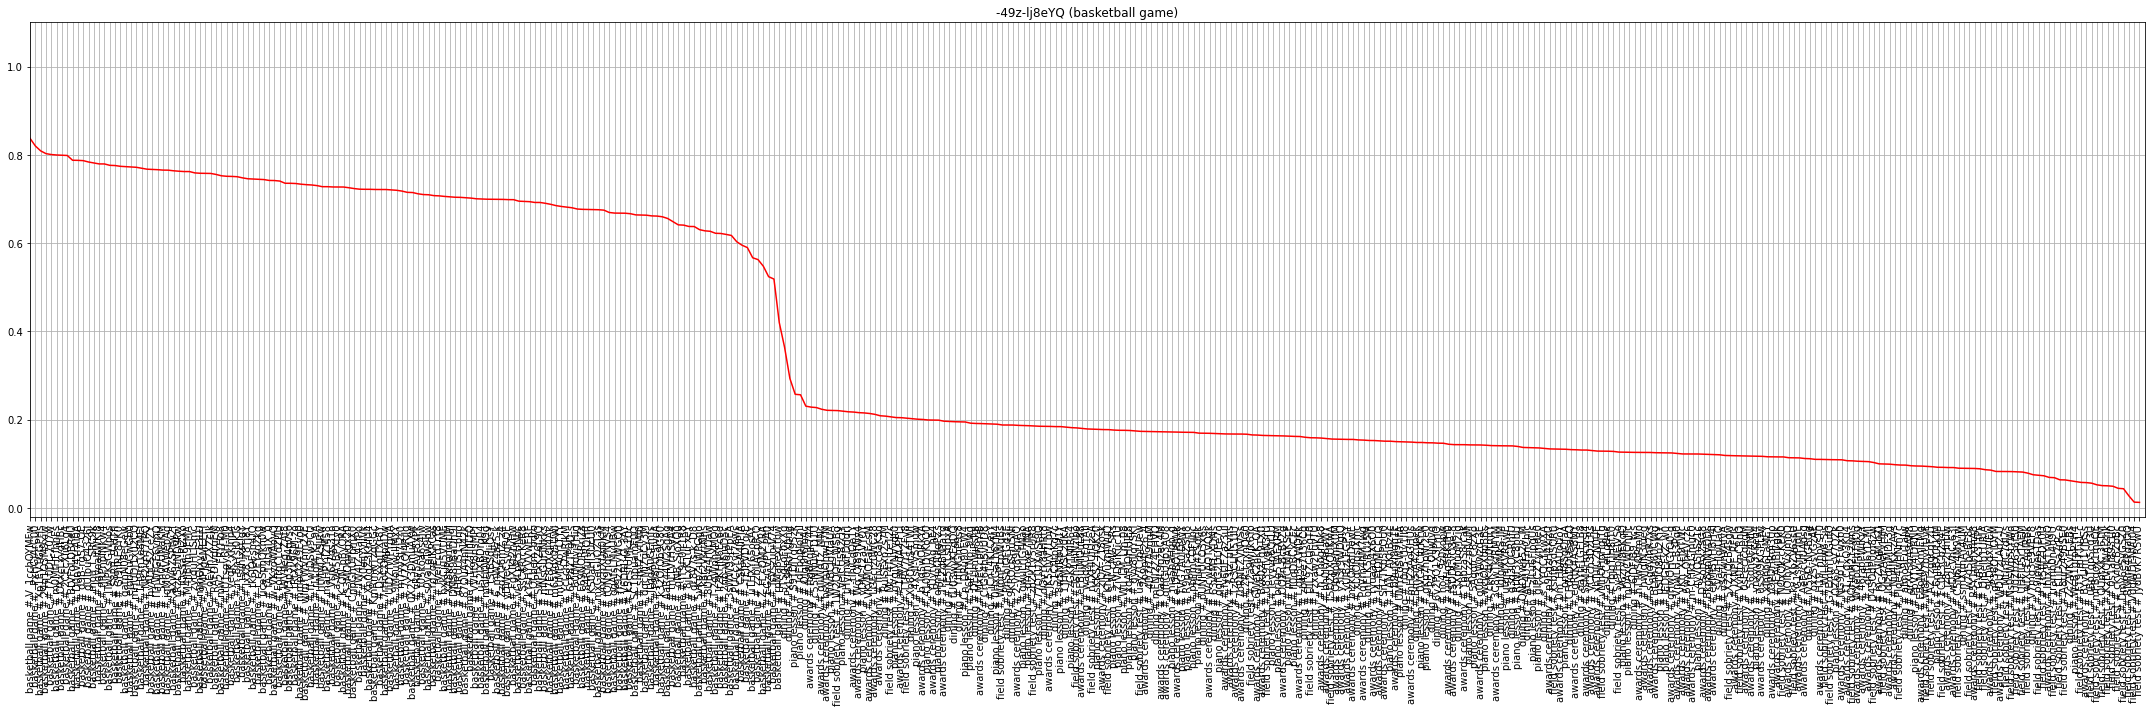

['dining # DEUmwjPsIgI', 'dining # CrG64hSvUD8', 'dining # c55NNuvFD1U', 'dining # YlflNGhP9s8', 'dining # jE5lKLsbpxA', 'awards ceremony # qfhGUap3AO8', 'dining # S1CfItpKg7c']


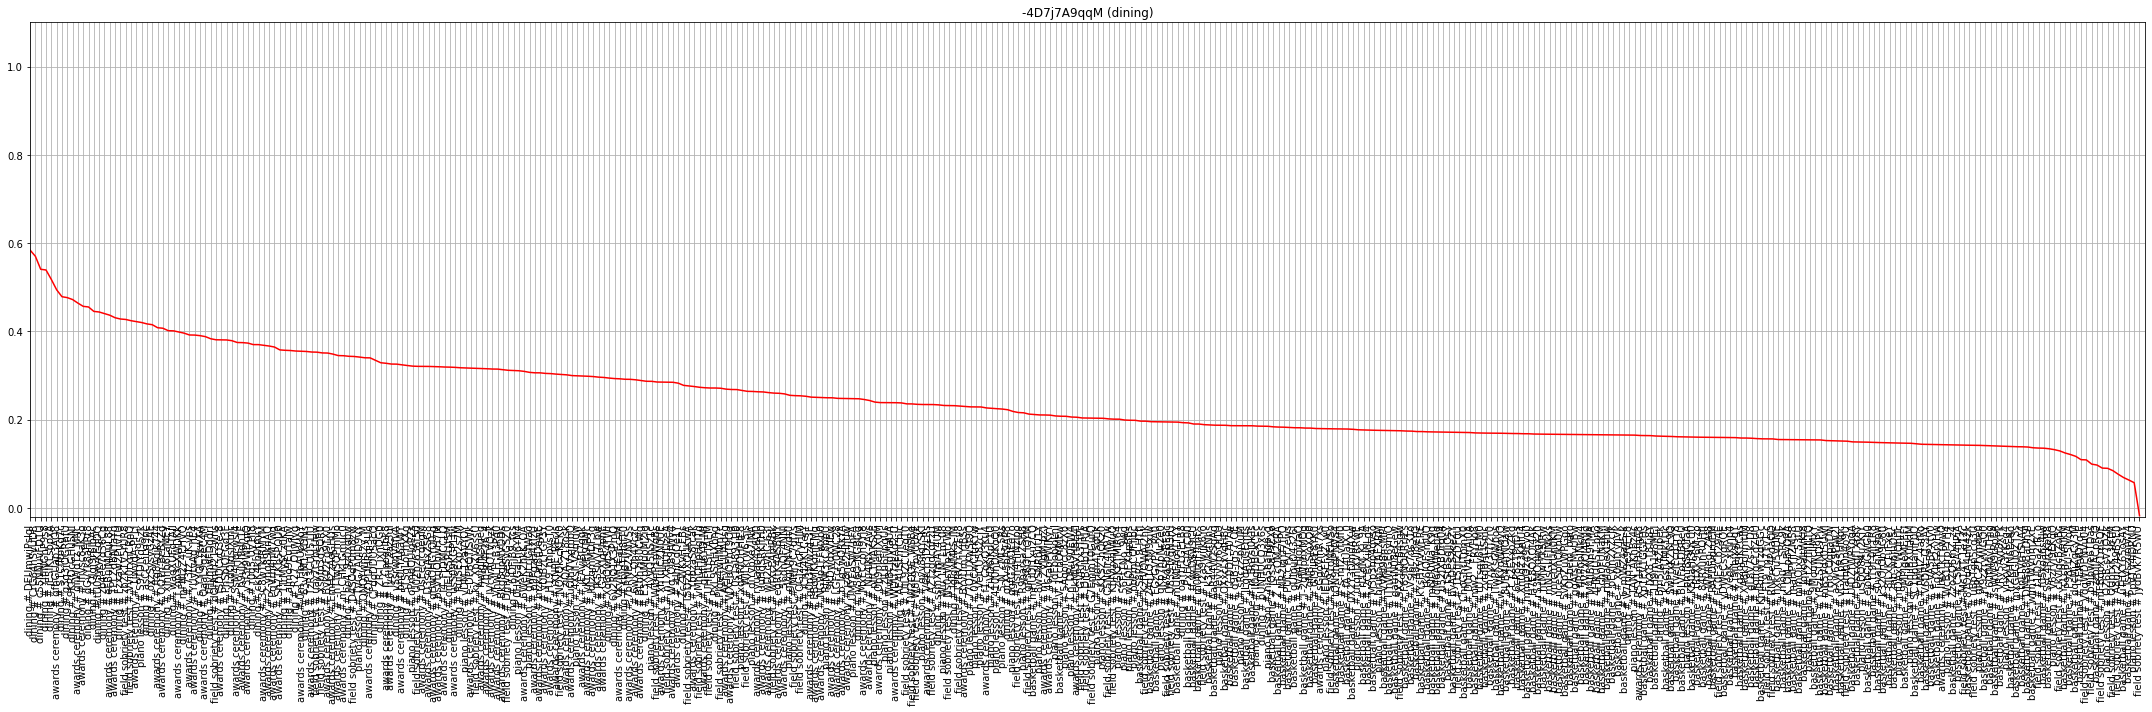

['piano lesson # gKp7hpNr2e0', 'piano lesson # uSDQ84u2KiY', 'piano lesson # ynxyv3YKeg4', 'piano lesson # plfCtMAKScE', 'piano lesson # VeICU582ciY', 'piano lesson # 7Hdr4TSdtjk', 'piano lesson # wcjOEXdpBBs']


KeyboardInterrupt: 

In [20]:
ids_act = moma.get_ids_act(split="val")
for i, act_q in enumerate(moma.get_anns_act(ids_act)):
    q_emb = cache[act_q.id]
    ref_embs, x_label = [], []
    for act_r in moma.get_anns_act(ids_act):
        if act_q.id == act_r.id:
            continue
        ref_embs.append(cache[act_r.id])
        x_label.append(act_r.cname + " # " + act_r.id)

    relevances = []
    for r_emb in ref_embs:
        relevances.append(cosine_mean_similarity(q_emb, r_emb))
        # relevances.append(smooth_chamfer_similarity(q_emb, r_emb, 16))
    relevances = torch.stack(relevances)

    sorted_relevances, sorted_idx = torch.sort(relevances, descending=True)
    sorted_relevances = sorted_relevances.cpu().numpy()
    x_label = [x_label[idx] for idx in sorted_idx]

    plt.figure(figsize=(30, 10))
    plt.title(f"{act_q.id} ({act_q.cname})")
    plt.xticks(np.arange(len(x_label)), label=x_label, rotation=90)
    plt.gca().set_xticklabels(x_label)
    plt.xlim([0, len(x_label)])
    plt.ylim([-0.02, 1.1])
    plt.grid(True)
    plt.tight_layout()

    print(x_label[:7])
    plt.plot(np.arange(len(sorted_relevances)), sorted_relevances, color="red")
    plt.show()

    if i == 5:
        break